# Import & Packages - Pas toucher

In [1]:
!pip install scikeras

In [4]:
proj_dir = '/content/drive/MyDrive/Colab Notebooks/Nb Factures - Previsionnel/'
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
#@title Import
# Accès aux fichiers du Drive
from google.colab import drive, files

# Dates
from datetime import date, timedelta
import datetime as dt
import calendar
# import holidays

# Gestion de données
import numpy as np
import pandas as pd

# Graphiques/DataViz
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [4]:
#@title Import
fc23 = pd.read_csv(r'/content/drive/MyDrive/Projets PàD/Nb Factures - Previsionnel/Factures 2023.csv', sep=";")
fc23.dt_fact = pd.to_datetime(fc23.dt_fact)

In [23]:
#@title Groupage par jour
df = fc23.query('statut == "REG" & ttc > 0') \
    .groupby('dt_fact') \
    .count()[['statut']] \
    .reset_index() \
    .rename(columns={'statut':'val', 'dt_fact':'date'})

In [24]:
df['val'] = df['val'].apply(lambda x: int(0 if x <= 1 else 0.06*x + 48))

# Data cleaning and feature engineering

(à inclure dans le Readme)

**Motivation :** L'étude consiste à visualiser le nombre de Simflouz générés (cf NB) par jour sur l'année 2023. L'idée m'est venue de plateformes de cours et de coaching (LeetCode, Valorant Tracker) qui offrent des heatmaps mensuelles montrant l'aciduité de l'élève. Des couleurs intenses sur une journée montrent que l'élève a par exemple réalisé beaucoup d'exercices dans la journée, ou bien a soumis tant de codes, joué tant de parties, etc. Une couleur grisée indique une absence d'activité sur le jour.

**Idée :** En se basant sur cette expérience, le but de ce projet est donc de réaliser un graphique offrant ce concept, mois par mois, sur l'année 2023, en se basant sur l'évolution annuelle du nombre de Simflouz.

**NB :** Le jeu de données utilisées provient de la société dans laquelle j'ai effectué mon stage de fin d'études réalisé dans le cadre de mon master Méthodes Stochastiques et Informatiques pour la Décision. \
Les valeurs et variables présentées ont donc été modifiées pour des raisons de confidentialité, ce qui ne change rien à l'analyse.


In [40]:
df.describe()

,date,cpt
count,252,252.000000
mean,2023-07-01 01:02:51.428571392,84.849206
min,2023-01-02 00:00:00,0.000000
25%,2023-03-29 18:00:00,73.000000
50%,2023-07-01 12:00:00,83.000000
75%,2023-09-29 18:00:00,92.000000
max,2023-12-29 00:00:00,175.000000
std,NaN,19.057501


In [25]:
#@title Fonctions - Data engineering
liste_mois = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

def fill_days_2023(df:pd.DataFrame) -> pd.DataFrame:
    """
    Complète un DataFrame en y imputant les dates manquantes, affectant 0 aux valeurs manquantes.
    """
    days_list = [dt.date(2023, 1, 1) + timedelta(days=x) for x in range((dt.date(2023, 12, 31) - dt.date(2023, 1, 1)).days + 1)]
    all_days = pd.DataFrame({'date' : pd.to_datetime(days_list)})
    df_all_days = all_days.merge(df, how='left')
    df_all_days.fillna(0, inplace=True)
    df_all_days['val'] = df_all_days['val'].astype(int)
    return df_all_days

def ajout_colonnes(df: pd.DataFrame) -> pd.DataFrame:
    df['jour'] = df.date.dt.day
    df['mois'] = df.date.dt.month
    df['semestre'] = df.apply(lambda row: 1 if row.mois<7 else  2, axis=1)
    df['an'] = df.date.dt.year

    df['mois'] = df.mois.map({i:mois for i, mois in enumerate(liste_mois, 1)}) # ou apply liste_mois[x-1]
    # df['jourdesem'] = df.date.dt.day_of_week

    # Gestion des jours ouvrables
    # jours_feries = [date for date, name in sorted(holidays.CountryHoliday('FRA', years=[2023]).items())]
    # df['is_ferie'] = df.date.isin(jours_feries).astype(int)
    # df['is_weekend'] = df.jourdesem.isin([5,6]).astype(int)
    # df['is_ouvrable'] = df.apply(lambda row: not(row.is_ferie or row.is_weekend), axis=1).astype(int)

    return df

In [27]:
df_all_days = fill_days_2023(df)
df_all_days = ajout_colonnes(df_all_days)

In [30]:
df_all_days.head()

,date,cpt,jour,mois,semestre,an
0,2023-01-01,0,1,Janvier,1,2023
1,2023-01-02,58,2,Janvier,1,2023
2,2023-01-03,60,3,Janvier,1,2023
3,2023-01-04,54,4,Janvier,1,2023
4,2023-01-05,61,5,Janvier,1,2023


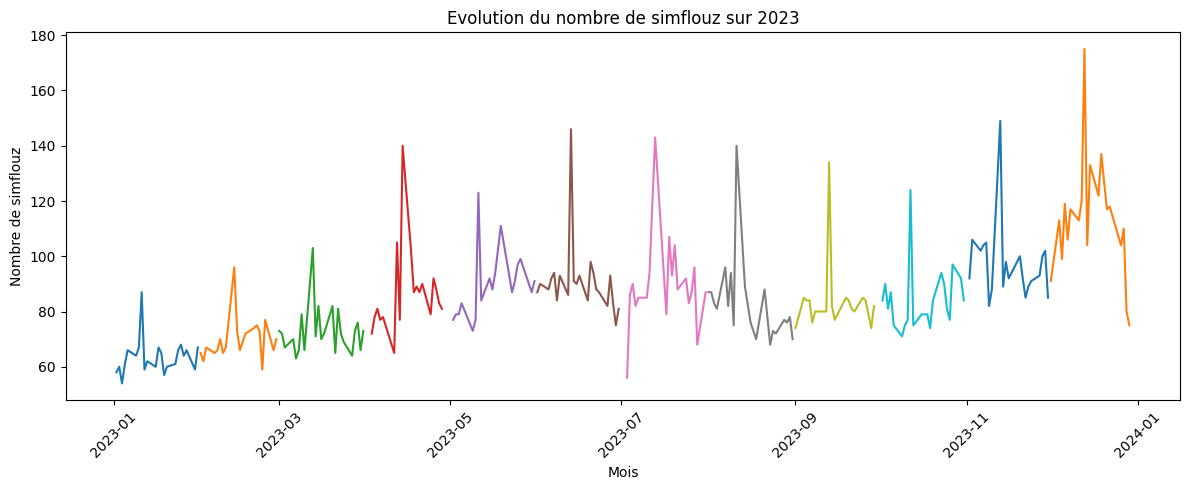

In [29]:
#@title Évolution du nombre de simflouz sur 2023
plt.figure(figsize=(12, 5))

df_nn = df_all_days[df_all_days['val'] > 0]
for idx_mois in df_nn['mois'].unique():
    plt.plot(df_nn.loc[df_nn['mois'] == idx_mois, 'date'],
             df_nn.loc[df_nn['mois'] == idx_mois, 'val'],
             label=idx_mois)

plt.xlabel('Mois')
plt.ylabel('Nombre de simflouz')
plt.title('Evolution du nombre de simflouz sur 2023')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Répartition du nombre de simflouz par mois')

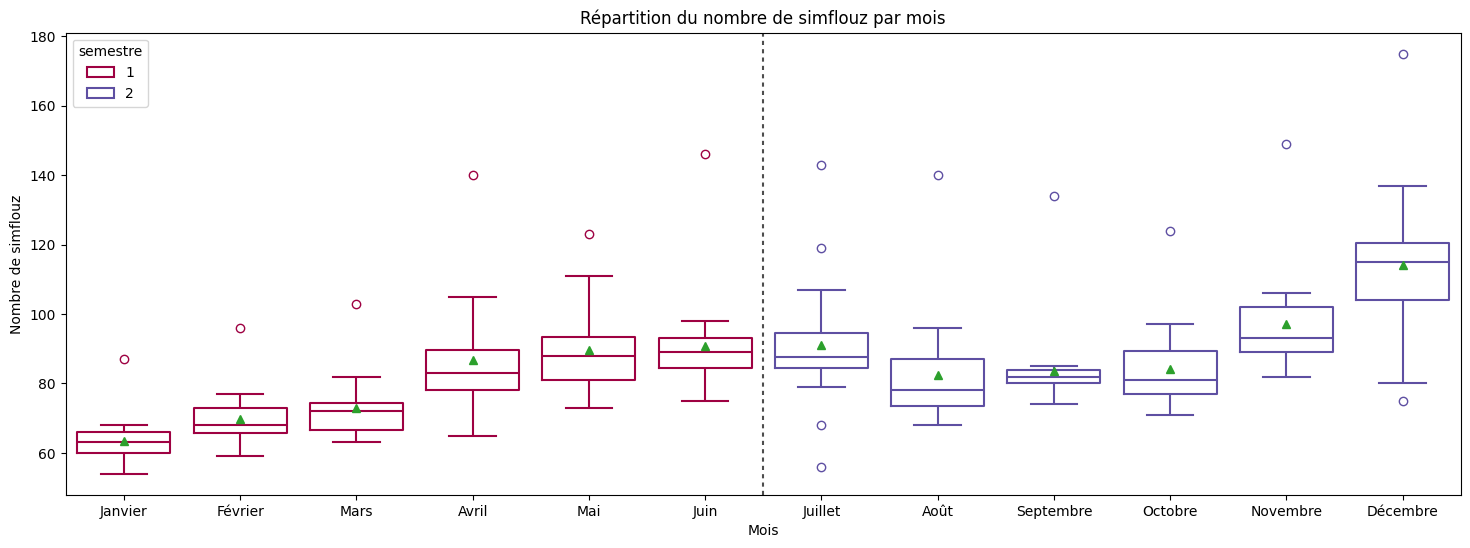

In [28]:
#@title Diagrammes en boîte mensuels (parce que c'est joli)
# Box Plot
plt.figure(figsize=(18, 6))

sns.boxplot(data=df_all_days.query('val > 0'),
            x='mois',
            y='val',
            hue='semestre',
            palette='Spectral',
            fill=False,
            showmeans=True)

plt.xlabel('Mois')
plt.ylabel('Nombre de simflouz')
plt.axvline(5.5, color=".3", dashes=(2, 2))
plt.title('Répartition du nombre de simflouz par mois')

On constate généralement un seul pic par mois. De plus, la moyenne et la médiane sont proches, ce qui évite un dilemme concernant le choix des niveaux pour la colormap plus tard.

In [31]:
#@title Sous-fonctions pour le calendrier
def create_colormap(pos_val: pd.Series) -> LinearSegmentedColormap:
    """
    Crée une colormap se basant sur les quantiles de données strictement positives.

    PARAMETRE
    ----------
    pos_val : Série de valeurs strictement positives

    RETOUR
    ----------
    cmap_global : Colormap normalisée avec des tons de vert, du rouge pour la valeur maximale,
    du gris pour les valeurs négatives.

    levels : Niveaux de la colormap

    levels_norm : Niveaux de la colormap normalisés
    """
    levels = [
        0,
        pos_val.quantile(0.25),
        pos_val.median(),
        pos_val.quantile(0.75),
        pos_val.max()
    ]

    # Normalisation des niveaux
    levels_norm = np.linspace(0, 1, len(levels))
    colors = [
        '#e0f7e9',  # Couleur pour le minimum
        '#b2e2a6',  # Couleur pour le 1er quartile
        '#66c066',  # Couleur pour la médiane
        '#31a354',  # Couleur pour le 3e quartile
        'firebrick'  # Couleur pour le maximum
    ]

    # Création de la colormap
    cmap_global = LinearSegmentedColormap.from_list("custom_green", list(zip(levels_norm, colors)))
    cmap_global.set_extremes(under='gainsboro')  # Valeurs négatives en gris
    return cmap_global, levels, levels_norm


def generate_week_labels(df_mois, nb_semaines, sem_plus_deb):
    """
    Génère les étiquettes de semaines pour un mois donné.

    PARAMETRES
    ----------
    df_mois : pd.DataFrame
        DataFrame contenant les données pour le mois en cours avec une colonne 'date'.

    nb_semaines : int
        Nombre de semaines à afficher.

    sem_plus_deb : bool
        Indique s'il y a un décalage pour la première semaine.

    RETOUR
    ------
    weeks_labels : list of str
        Liste des libellés de semaines avec le numéro de semaine et les dates de début et de fin.
    """
    weeks_labels = []
    for i in range(nb_semaines):
        start_date = (df_mois['date'].iloc[0] + pd.DateOffset(weeks=i - sem_plus_deb)).to_period('W').start_time
        end_date = start_date + pd.DateOffset(days=6)
        weeks_labels.append(f'Semaine {start_date.isocalendar()[1]}\n{start_date.strftime("%d/%m")} - {end_date.strftime("%d/%m")}')
    return weeks_labels

In [32]:
#@title Fonction principale : Génération du calendrier
def calendrier(df: pd.DataFrame, save: bool = False) -> None:
    """
    Crée un calendrier thermique représentant le nombre de simflouz
    sur une période donnée, avec la possibilité de sauvegarder le graphique.

    PARAMETRES
    ----------
    df : pd.DataFrame
        DataFrame contenant les données de satisfaction. Doit inclure au moins les colonnes
        nécessaires pour le calcul, comme 'date', 'val', 'mois', et 'an'.

    save : bool, optionnel
        Indique si le graphique doit être sauvegardé en tant que fichier image.
        Par défaut, False.

    RETOUR
    -------
    None
        Affiche un graphique de type Matplotlib et peut sauvegarder
        ce dernier selon le paramètre `save`.

    NOTES
    ------
    Erreurs rencontrées lors de l'affichage :
    - Chiffres illisibles :
        => Les nombres sont au format réel et non entier OU
        => Plusieurs années se superposent
    - Problème d'échelle :
        => Oubli de rescaling (pertinent lors de la prédiction)
    - Cases identifiées mais vides (couleur vert menthe) :
        => Problème de format de données, passer en array ou Series
    """
    # Traitement données
    annee = df.an[0]
    df = df[df.an == annee]

    # Imputation de données en 2024 : Insertion des prédictions
    # df = df[df.an == annee].copy().reset_index()
    # df.loc[(df.an == annee) & (df.semestre == 2) & (df.is_ouvrable), 'val'] = pred
    # df['val'] = df['val'].fillna(0).astype(int)

    # Création colormap personnalisée
    val_positive = df[df.val > 0]['val']
    cmap_global, levels, levels_norm = create_colormap(val_positive)

    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 18))
    for idx_mois, mois in enumerate(liste_mois):
        # Subdivision mensuelle du calendrier
        df_mois = df[df['mois'] == mois][['date', 'val']]

        # Calcul du nombre de semaines à afficher
        df_mois['sem'] = df_mois['date'].apply(lambda x: x.isocalendar()[1])
        sem_deb, sem_fin = df_mois['sem'].iloc[0], df_mois['sem'].iloc[-1]
        nb_semaines = len(pd.unique(df_mois['sem']))
        calendar_matrix = np.zeros((nb_semaines, 7))

        # Cas : Aucun point la première semaine (ex: week-end en début de mois)
        first_day = df_mois['date'].iloc[0]
        sem_plus_deb = sem_deb != date(first_day.year, first_day.month, 1).isocalendar()[1]
        # Cas : Aucun point la dernière semaine (ex: week-end en fin de mois)
        last_day = df_mois['date'].iloc[-1]
        sem_plus_fin = sem_fin != date(last_day.year, last_day.month, calendar.monthrange(annee, last_day.month)[1]).isocalendar()[1]

        # Traitement des jours hors-mois
        calendar_matrix[0][:date(first_day.year, first_day.month, 1).weekday()] = -1
        calendar_matrix[-1][1 + date(last_day.year, last_day.month, calendar.monthrange(annee, last_day.month)[1]).weekday():] = -1

        # Remplissage de la matrice
        for idx, row in df_mois.iterrows():
            day_of_week = row['date'].weekday()
            sem_du_mois = row['sem']
            if sem_deb > sem_fin:
                if mois == 'Janvier':
                    sem_du_mois = sem_du_mois % sem_deb if sem_du_mois != sem_deb else 0
                else:
                    sem_du_mois = sem_du_mois % sem_deb if sem_du_mois > 1 else nb_semaines - 1
            else:
                sem_du_mois -= sem_deb
            calendar_matrix[sem_du_mois + sem_plus_deb, day_of_week] = row['val']

            # Remplissage des cases du graphique
            if row['val'] > 0:
                axs[idx_mois // 3, idx_mois % 3].text(day_of_week, sem_du_mois + sem_plus_deb + sem_plus_fin,
                                                        f'{row["val"]}', ha='center', va='center', color='black')

        # Calcul des dates délimitant chaque semaine
        weeks_labels = generate_week_labels(df_mois, nb_semaines, sem_plus_deb)

        row, col = idx_mois // 3, idx_mois % 3
        ax = axs[row, col]

        # Affichage graphiques, titres, axes
        ax.imshow(calendar_matrix, cmap=cmap_global, aspect='auto', interpolation='nearest', vmin=0, vmax=val_positive.max())
        ax.set_title(mois)
        ax.set_xticks(np.arange(7))
        ax.set_xticklabels(['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'])
        ax.set_xlabel('Jour de la semaine')
        ax.set_yticks(np.arange(nb_semaines))
        ax.set_yticklabels(weeks_labels)

        # Ajout d'une barre de couleur
        cbar = ax.figure.colorbar(plt.cm.ScalarMappable(cmap=cmap_global), shrink=0.95, ax=ax, orientation='vertical')
        cbar.ax.set_ylabel("simflouz", rotation=-90, va="bottom")
        cbar.ax.set_yticks(ticks=levels_norm)
        cbar.ax.set_yticklabels([int(level) for level in levels])

    plt.suptitle('Évolution quotidienne de simflouz sur 2023', fontsize=18, y=1)
    plt.tight_layout()

    # Sauvegarde fichier
    if save:
        plt.savefig("Calendrier 2023.png")
    plt.show()

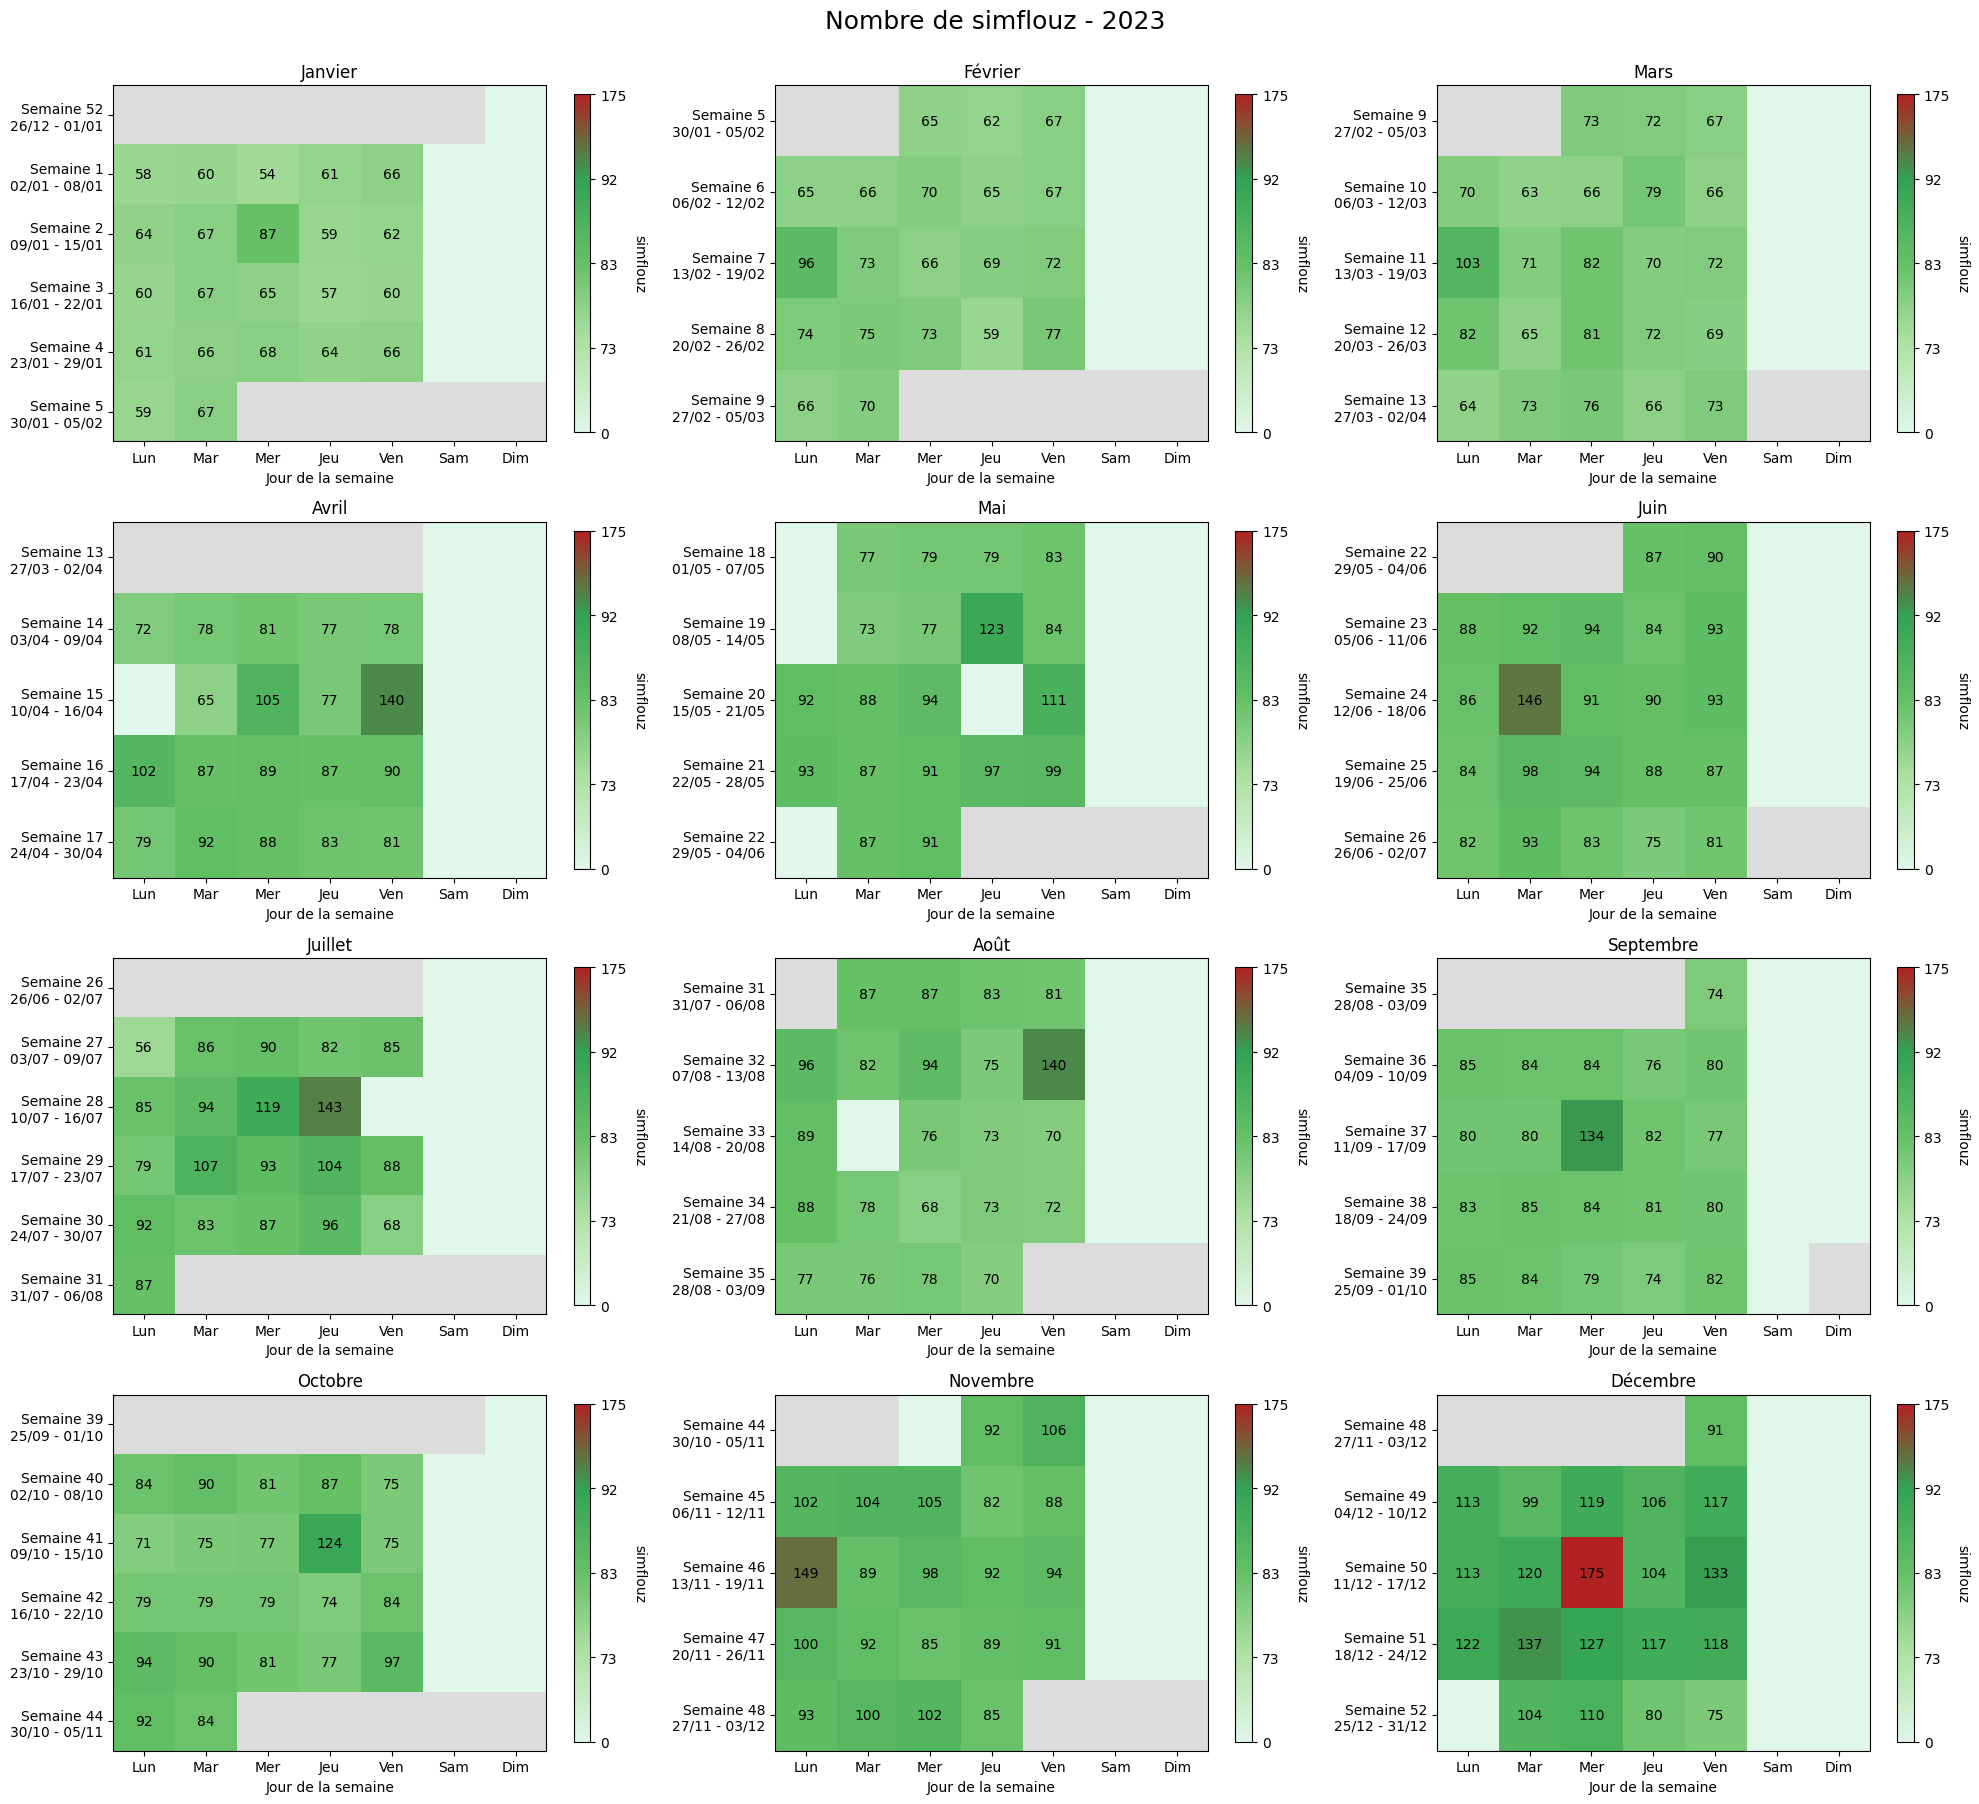

In [36]:
calendrier(df_all_days)